In [1]:
import librosa
from librosa.display import specshow
import os
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
import torch as torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
import json
from paramManager import paramManager
from pathlib import Path
import soundfile as sf
import time
import math

torch.__version__

'1.7.1'

In [2]:
audio_valid_dir = '/home/purnima/appdir/Github/DATA/NSynth/nsynth-valid/audio/'
labels_valid_dir = '/home/purnima/appdir/Github/DATA/NSynth/nsynth-valid/'

audio_train_dir = '/home/purnima/appdir/Github/DATA/NSynth/nsynth-train/audio/'
labels_train_dir = '/home/purnima/appdir/Github/DATA/NSynth/nsynth-train/'

audio_test_dir = '/home/purnima/appdir/Github/DATA/NSynth/nsynth-test/audio/'
labels_test_dir = '/home/purnima/appdir/Github/DATA/NSynth/nsynth-test/'

file = 'keyboard_electronic_001-021-127.wav'

audio_d, s_r = librosa.load(os.path.join(audio_test_dir, file), sr=16000)

In [3]:
#
# Prof's code.
#

from librosa.core import magphase

def stft(x):
    return librosa.core.stft(
            x,
            hop_length=512,
            win_length=1024,
            n_fft=1024)

def mag_phase_angle(x):
    mag, ph = magphase(x)
    ph = np.angle(ph)
    out = np.stack([mag, ph])
    return out

def safe_log(x):
    return torch.log(x + 1e-10)

def safe_log_spec(x):
    if type(x) == np.ndarray:
        x = torch.from_numpy(x)
    if x.size(0) == 2:
        mag = x[0]
        ph = x[1]
        mlog = safe_log(mag)
        return torch.stack([mlog, ph], dim=0)
    elif x.size(0) == 1:
        return safe_log(x)

def instantaneous_freq(specgrams):
    if specgrams.shape[0] != 2:
      ph = specgrams
    else:
      mag = specgrams[0]
      ph = specgrams[1]

    #first unwrap (phase keeps growing, no mod 2pi)
    uph = np.unwrap(ph, axis=1)
    #now take the difference between phase at this frame minus phase at previous frame
    uph_diff = np.diff(uph, axis=1)
    ifreq = np.concatenate([ph[:, :1], uph_diff], axis=1)

    if specgrams.shape[0] == 2:
      return np.stack([mag, ifreq/np.pi])
    else:
      return ifreq


def encode(x,sr) :
    c = librosa.core.stft(
            x,
            hop_length=512,
            win_length=1024,
            n_fft=1024)
    mp= mag_phase_angle(c)
    #rm dc freq bin
    lspect=safe_log_spec(mp)
    return instantaneous_freq(lspect)

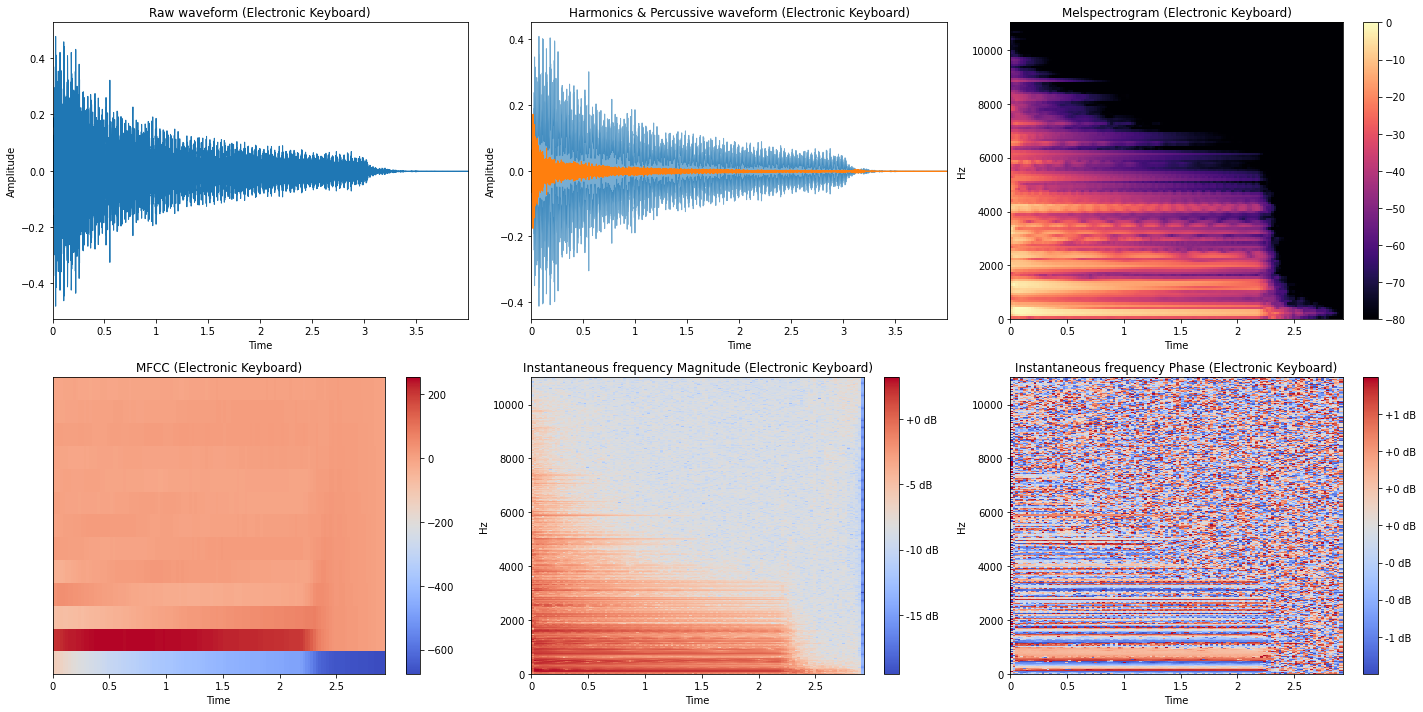

In [4]:
f = plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.01, right=0.1, bottom=0.05, top=0.7)

# 1. Raw wave
ax = f.add_subplot(231)
ax.set_title('Raw waveform (Electronic Keyboard)')
ax.set_ylabel('Amplitude')
librosa.display.waveplot(audio_d, sr=s_r)

# 1. Raw wave HPSS
ax = f.add_subplot(232)
audio_d_hpss = librosa.effects.hpss(audio_d)
ax.set_title('Harmonics & Percussive waveform (Electronic Keyboard)')
ax.set_ylabel('Amplitude')
librosa.display.waveplot(audio_d_hpss[0], sr=s_r, alpha=0.6)
librosa.display.waveplot(audio_d_hpss[1], sr=s_r)

# 2. Mel spectrogram
ax = f.add_subplot(233)
ax.set_title('Melspectrogram (Electronic Keyboard)')
melspect = librosa.feature.melspectrogram(audio_d, sr=s_r)
melspect = librosa.power_to_db(melspect, ref=np.max)
librosa.display.specshow(melspect, x_axis='time', y_axis='linear')
plt.colorbar()

# 3. MFCCs
ax = f.add_subplot(234)
ax.set_title('MFCC (Electronic Keyboard)')
mfcc = librosa.feature.mfcc(audio_d, sr=s_r, n_mfcc=13)
librosa.display.specshow(mfcc, x_axis='time')
plt.tight_layout()
plt.colorbar()

# 4. IF
ax = f.add_subplot(235)
ax.set_title('Instantaneous frequency Magnitude (Electronic Keyboard)')
a_ifspect = encode(audio_d, s_r)
img = librosa.display.specshow(a_ifspect[0], x_axis='time', y_axis='linear')
f.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()

ax = f.add_subplot(236)
ax.set_title('Instantaneous frequency Phase (Electronic Keyboard)')
img = librosa.display.specshow(a_ifspect[1], x_axis='time', y_axis='linear')
f.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()

plt.savefig('waveforms.png')